<a href="https://www.kaggle.com/code/ghostlyboy/flower-cnn?scriptVersionId=256476844" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!rm -rf /kaggle/working/*
!rm -rf /kaggle/working/Flowers
!rm /kaggle/working/Flower.zip

rm: cannot remove '/kaggle/working/Flower.zip': No such file or directory


# **G-Drive and Dataset downloading**

In [2]:
# Install gdown (only needs to run once)
!pip install -q gdown
# Download the ZIP file from Google Drive
!gdown --id 1nzf5b_NNJlnInkueIWCOG7PWFv-Zk2Wk --output Flower.zip
# Unzip the dataset
!unzip -q Flower.zip -d Flower
# Delete the ZIP file to save space
import os
os.remove("Flower.zip")

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nzf5b_NNJlnInkueIWCOG7PWFv-Zk2Wk
From (redirected): https://drive.google.com/uc?id=1nzf5b_NNJlnInkueIWCOG7PWFv-Zk2Wk&confirm=t&uuid=a4a03995-192b-4f5e-a0cc-191220877397
To: /kaggle/working/Flower.zip
100%|████████████████████████████████████████| 145M/145M [00:02<00:00, 55.4MB/s]


In [4]:
import os
os.environ["TF_DISABLE_LAYOUT_OPTIMIZER"] = "1"

# **Imports**

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score)

# **Configuration**

In [7]:
# Seed value to ensure reproducibility across runs (helps make results consistent)
SEED = 42

# Number of images per batch during training/validation
BATCH_SIZE = 32

# Size to which all images will be resized (256x256 pixels)
IMAGE_SIZE = 256

# Number of color channels in each image (3 for RGB)
CHANNELS = 3

# Total number of times the entire dataset will be passed through the model
EPOCHS = 100

# Fraction of the dataset to be used for training (60%)
TRAIN_SPLIT = 0.6

# Fraction of the dataset to be used for validation (20%)
VAL_SPLIT = 0.2

DATA_PATH    = "/kaggle/working/Flower"

tf.random.set_seed(SEED)
np.random.seed(SEED)

# **Load Full Dataset**

In [9]:
full_ds = image_dataset_from_directory(
    DATA_PATH,
    shuffle=True,
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)

Found 5959 files belonging to 5 classes.
Detected classes: ['Astilbe', 'Dandelion', 'Magnolia', 'Rose', 'Sunflower']


# **Visual sanity‑check**

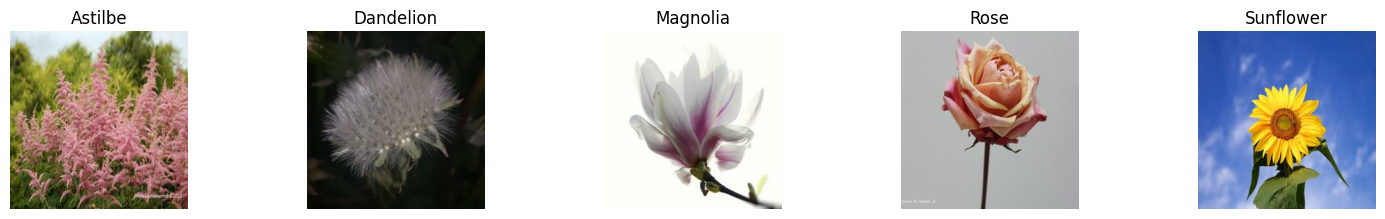

In [16]:
def show_one_sample_per_class(ds, class_names):
    num_classes = len(class_names)
    class_images = {}

    # Loop through unbatched dataset to find one image per class
    for image, label in ds.unbatch():
        label_val = int(label.numpy())
        if label_val not in class_images:
            class_images[label_val] = image.numpy().astype("uint8")
        if len(class_images) == num_classes:
            break

    if len(class_images) < num_classes:
        print("Not all classes found in the dataset!")
        return

    # Sort by label index for consistent order
    sorted_items = sorted(class_images.items())

    plt.figure(figsize=(15, 10))
    for i, (label, img) in enumerate(sorted_items):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
show_one_sample_per_class(full_ds, class_names)

# **Train / Val / Test split**

In [17]:
dataset_size  = tf.data.experimental.cardinality(full_ds).numpy()
train_batches = int(dataset_size * TRAIN_SPLIT)
val_batches   = int(dataset_size * VAL_SPLIT)

train_ds      = full_ds.take(train_batches)
temp_ds       = full_ds.skip(train_batches)
val_ds        = temp_ds.take(val_batches)
test_ds       = temp_ds.skip(val_batches)

print(f"Dataset split (batches) -> train: {train_batches}, val: {val_batches}, test: {dataset_size - train_batches - val_batches}")

Dataset split (batches) -> train: 112, val: 37, test: 38


# **Performance Boosters**

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Pre‑processing & Augmentation Layers**

In [19]:
resize_and_rescale = layers.Rescaling(1./255)
data_augmentation  = models.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal"),
])

# **CNN model**

In [20]:
def make_model():
    model = models.Sequential([
        layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        resize_and_rescale,
        data_augmentation,

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.15),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.15),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.20),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.30),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = make_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,649,221 (128.36 MB)

 Trainable params: 33,649,221 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

# **Compile & Train**

In [21]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_flower_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    )
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/100


E0000 00:00:1752291559.998939      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1752291561.601755     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.3859 - loss: 2.1567 - val_accuracy: 0.6613 - val_loss: 0.8396
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.6661 - loss: 0.8524 - val_accuracy: 0.7035 - val_loss: 0.7743
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6938 - loss: 0.7749 - val_accuracy: 0.7492 - val_loss: 0.6952
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7446 - loss: 0.6616 - val_accuracy: 0.7965 - val_loss: 0.5898
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.7559 - loss: 0.6315 - val_accuracy: 0.8294 - val_loss: 0.5339
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.7794 - loss: 0.5832 - val_accuracy: 0.8167 - val_loss: 0.5331
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.7791 - loss: 0.5623 - val_accuracy: 0.7973 - val_loss: 0.5407
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.7926 - loss: 0.550

# **Evaluate on Test set**

In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test accuracy: {test_acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9025 - loss: 0.4707

✅ Test accuracy: 0.8942


# **Metrics & confusion matrix**


Primary metrics (macro)
Acc : 0.8942
F1  : 0.8837
Precision: 0.8791
Recall   : 0.8922
ROC‑AUC  : 0.9862

Detailed report
               precision    recall  f1-score   support

     Astilbe       0.75      0.91      0.82       129
   Dandelion       0.93      0.91      0.92       418
    Magnolia       0.87      0.79      0.83       220
        Rose       0.87      0.89      0.88       205
   Sunflower       0.98      0.96      0.97       219

    accuracy                           0.89      1191
   macro avg       0.88      0.89      0.88      1191
weighted avg       0.90      0.89      0.89      1191



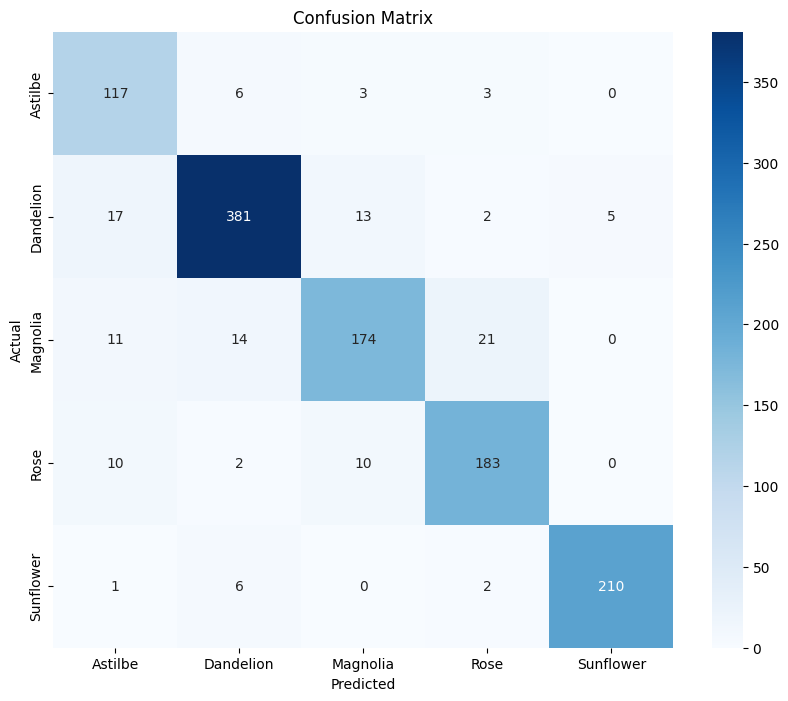

In [24]:
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    prob_batch = model.predict(images, verbose=0)
    preds      = np.argmax(prob_batch, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(prob_batch)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc  = accuracy_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred, average="macro")
prec = precision_score(y_true, y_pred, average="macro")
rec  = recall_score(y_true, y_pred, average="macro")
try:
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
except ValueError:
    auc = None

print(f"\nPrimary metrics (macro)\n"
      f"Acc : {acc:.4f}\nF1  : {f1:.4f}\nPrecision: {prec:.4f}\nRecall   : {rec:.4f}")
if auc:
    print(f"ROC‑AUC  : {auc:.4f}")

print("\nDetailed report\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Learning curves**

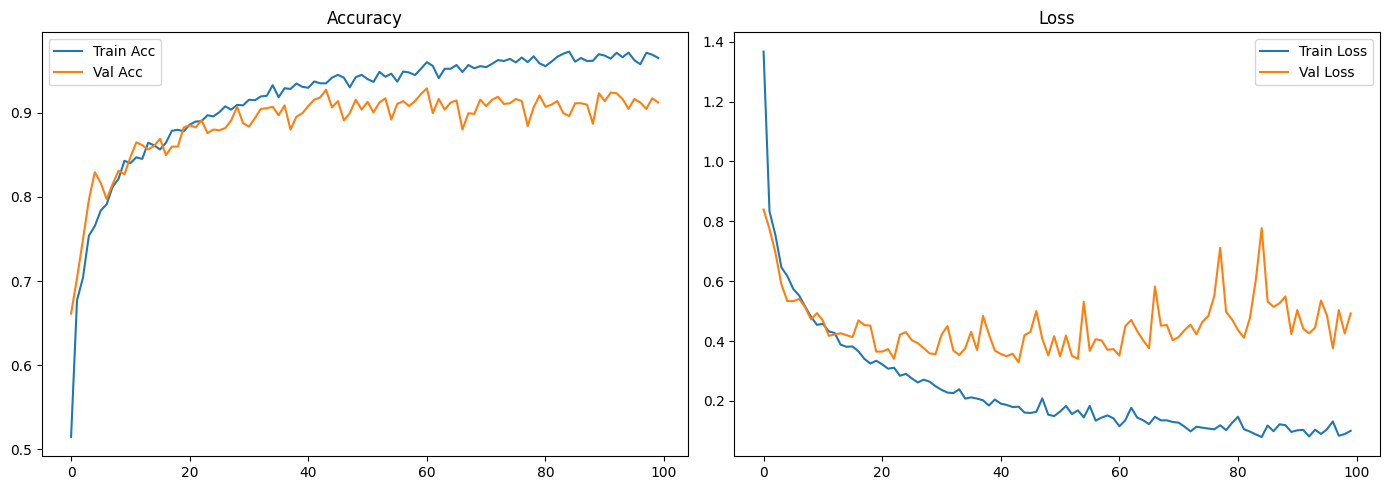

In [25]:
def plot_learning_curves(history):
    epochs_range = range(len(history.history["accuracy"]))
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history.history["accuracy"], label="Train Acc")
    plt.plot(epochs_range, history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, history.history["loss"], label="Train Loss")
    plt.plot(epochs_range, history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

# **Qualitative inspection**

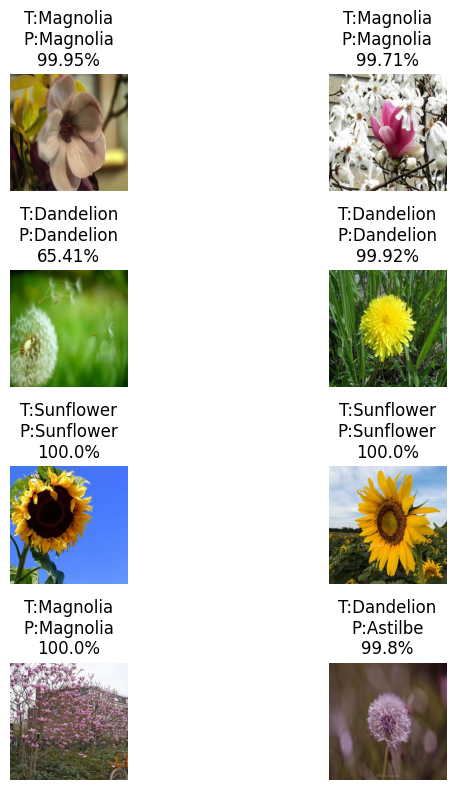

In [31]:
def predict_single(img):
    prob = model.predict(tf.expand_dims(img, 0), verbose=0)[0]
    return class_names[np.argmax(prob)], round(100*prob.max(), 2)

plt.figure(figsize=(8,8))
shown = 0
for images, labels in test_ds:
    for j in range(min(4, images.shape[0])):
        if shown == 8:
            break
        ax = plt.subplot(4,2, shown+1)
        img = images[j]
        pred_class, conf = predict_single(img)
        true_class = class_names[int(labels[j])]
        ax.imshow(img.numpy().astype("uint8"))
        ax.set_title(f"T:{true_class}\nP:{pred_class}\n{conf}%")
        ax.axis("off")
        shown += 1
    if shown == 8:
        break
plt.tight_layout()
plt.show()